# Лабораторная работа №8. Машинное обучение

### Распаковка архивов и подготовка данных

In [31]:
import tarfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.autograd import Variable
from tqdm import tqdm

In [ ]:
annotation_path = './annotation.tar'
images_path = './images.tar'

with tarfile.open(annotation_path, 'r:') as tar:
    tar.extractall(path='./annotations')

with tarfile.open(images_path, 'r:') as tar:
    tar.extractall(path='./images')

In [ ]:
annotations_dir = './annotations'
images_dir = './images'

print("Файлы аннотаций:", os.listdir(annotations_dir)[:5])
print("Файлы изображений:", os.listdir(images_dir)[:5])

print("Всего аннотаций:", len(os.listdir(annotations_dir)))
print("Всего изображений:", len(os.listdir(images_dir)))

Файлы аннотаций: ['Annotation']
Файлы изображений: ['Images']
Всего аннотаций: 1
Всего изображений: 1


In [20]:
top_level = os.listdir(annotations_dir)
print("Папки верхнего уровня в annotations:")
print(top_level)

subfolder_path = os.path.join(annotations_dir, top_level[0])
print("\nСодержимое папки:", subfolder_path)
print(os.listdir(subfolder_path)[:5])


Папки верхнего уровня в annotations:
['Annotation']

Содержимое папки: /content/drive/MyDrive/Labs_MO/annotations/Annotation
['n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_terrier', 'n02095314-wire-haired_fox_terrier', 'n02095570-Lakeland_terrier']


In [ ]:
images_base_dir = './images/Images'

data = []

for breed_folder in os.listdir(images_base_dir):
    breed_path = os.path.join(images_base_dir, breed_folder)

    if os.path.isdir(breed_path):
        if '-' in breed_folder:
            breed_name = breed_folder.split('-', 1)[1].replace('_', ' ')
        else:
            breed_name = breed_folder

        for img_file in os.listdir(breed_path):
            img_path = os.path.join(breed_path, img_file)
            if os.path.isfile(img_path):
                data.append({'image_path': img_path, 'breed': breed_name})

df = pd.DataFrame(data)

In [22]:
df.head()

,image_path,breed
0,/content/drive/MyDrive/Labs_MO/images/Images/n...,Chihuahua
1,/content/drive/MyDrive/Labs_MO/images/Images/n...,Chihuahua
2,/content/drive/MyDrive/Labs_MO/images/Images/n...,Chihuahua
3,/content/drive/MyDrive/Labs_MO/images/Images/n...,Chihuahua
4,/content/drive/MyDrive/Labs_MO/images/Images/n...,Chihuahua


In [24]:
df['breed'].nunique()

120

Породы закодируем по уникальным значениям и соберем датасет

In [8]:
le = LabelEncoder()
df['breed_id'] = le.fit_transform(df['breed'])

id_to_breed = dict(zip(range(len(le.classes_)), le.classes_))

Пример:             breed  breed_id
0       Chihuahua        17
152   Maltese dog        44
404      Pekinese        51
553      Shih-Tzu        63
767  Afghan hound         0

Всего пород: 120


In [9]:
class DogDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform or transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        breed_id = self.df.loc[idx, 'breed_id']

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        return image, torch.tensor(breed_id, dtype=torch.long)

### Подготовка к обучению

In [10]:
num_epochs = 100

z_dim = 100
num_classes = len(df['breed'].unique())
batch_size = 64
learning_rate = 0.0002
beta1 = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Создадим класс для для задания архитектуры нейронной сети - генератора

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3*64*64),
            nn.Tanh()
        )

    def forward(self, z, labels):
        if labels.min() == 1:
            labels = labels - 1

        c = self.label_embedding(labels)
        x = torch.cat([z, c], 1)
        return self.model(x).view(-1, 3, 64, 64)

То же самое сделаем для дискриминатора

In [12]:
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(3*64*64 + num_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_embedding(labels)
        x = torch.cat([img.view(img.size(0), -1), c], 1)
        return self.model(x)

In [13]:
criterion = nn.BCELoss()

generator = Generator(z_dim, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

Добавим генерацию изображений для визуализации промежуточных результатов обучения

In [14]:
def generate_images(generator, epoch, z_fixed, labels_fixed, save_path=None):

    generator.eval()
    with torch.no_grad():
        generated_images = generator(z_fixed, labels_fixed)

    grid = vutils.make_grid(generated_images, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f"Epoch {epoch}")

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f'epoch_{epoch}.png'))
    plt.show()

In [15]:
dataset = DogDataset(df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

fixed_z = torch.randn(64, z_dim, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), dtype=torch.long, device=device)

In [16]:
def train(generator, discriminator, dataloader, optimizer_g, optimizer_d, num_epochs=50, save_path=None):
    generator.to(device)
    discriminator.to(device)

    if save_path:
        os.makedirs(save_path, exist_ok=True)

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (imgs, labels) in pbar:
            batch_size = imgs.size(0)
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer_d.zero_grad()

            real_out = discriminator(imgs, labels)
            d_loss_real = criterion(real_out, real_labels)

            z = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(z, labels)
            fake_out = discriminator(fake_images.detach(), labels)
            d_loss_fake = criterion(fake_out, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()

            optimizer_g.zero_grad()
            fake_out = discriminator(fake_images, labels)
            g_loss = criterion(fake_out, real_labels)
            g_loss.backward()
            optimizer_g.step()

            pbar.set_postfix({
                "D Loss": f"{d_loss.item():.4f}",
                "G Loss": f"{g_loss.item():.4f}"
            })

        if epoch % 25 == 0 or epoch == 0:
            generate_images(generator, epoch, fixed_z, fixed_labels, save_path)

In [17]:
os.makedirs('./generated_images', exist_ok=True)

### Обучение и результаты

In [ ]:
train(generator, discriminator, dataloader, optimizer_g, optimizer_d, num_epochs=num_epochs, save_path='./generated_images')

Output hidden; open in https://colab.research.google.com to view.

По какому-то непонятному стечению обстоятельств обучение прервалось на последней эпохе

Только после возникновения этой ситуации стало понятно, что необходимо было добавить сохранение весов и моделей после каждой итерации обучения - это будет в списке возможных улучшений в дальнейшем

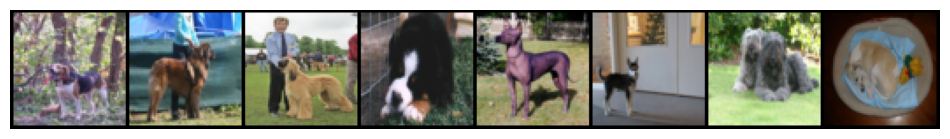

In [32]:
images, _ = next(iter(dataloader))
grid_img = torchvision.utils.make_grid(images[:8], nrow=8, normalize=True)
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

Можно заметить, что сгенерированные изображения очень сильно далеки от реальности, но неопределенные силуэты (предположительно собачек) на них определенно присутствуют, в связи с чем можно считать данный эксперимент удачным.

Лоссы показывают, что где-то до 10 эпохи наблюдаются пробные попытки моделей, а после 10 эпохи начинается полноценное обучение. Примерно после 70 эпохи начинает появляться своего рода устойчивость. Очевидно, чтобы обучиться хотя бы до приемлемого уровня, моделям понадобится еще некоторое количество времени.